In [1]:
import os
import json  # to serialize the best hyperparameters found
import warnings  # to suppress them

from mapie.subsample import Subsample  # for the CV folds in the UQ process
from scipy.stats import randint, uniform  # for the random search hyperparameters
from sklearn.model_selection import KFold, RandomizedSearchCV

from cp import data, visualize, validate, exchangeable, cv, logger as _logger
import matplotlib.pyplot as plt
import numpy as np

SEED: int = 123
np.random.seed(SEED)
MISCOVERAGE: float = 0.2 # MISCOVERAGE = alpha # CONFIDENCE = 1-alpha 
logger = _logger.Logger()
warnings.filterwarnings("ignore")  # to suppress them

This work was highly based on this [notebook](https://github.com/scikit-learn-contrib/MAPIE/blob/master/notebooks/regression/ts-changepoint.ipynb).

# Time series problem
Within this notebook, the "EnbPI" strategy ([Xu, Chen and Yao Xie (2021)](https://proceedings.mlr.press/v139/xu21h.html) ${}^{[1]}$) is implemented to estimate prediction intervals for time series' forecasts. In particular, the Victoria electricity demand dataset is used (as in the book: "Forecasting: Principles and Practice" by R. J. Hyndman and G. Athanasopoulos).

The electricity demand features daily and weekly seasonalities and is impacted
by the temperature, considered here as a exogeneous variable.

A Random Forest model will be used to fit the data (fine-tuning it using a randomized hyperparameters search, leveraging a sequential [`sklearn.model_selection.TimeSeriesSplit`](sklearn.model_selection.TimeSeriesSplit) cross validation), and then 'EnbPI' will be implemented through the [`mapie.time_series_regression.MapieTimeSeriesRegressor`](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieTimeSeriesRegressor.html) class.

${}^{[1]}$ Xu, Chen and Yao Xie (July 2021). “Conformal prediction interval for dynamic time-series”. In: Proceedings of the 38th International Conference on Machine Learning. Ed. Bibliography 29 by Marina Meila and Tong Zhang. Vol. 139. Proceedings of Machine Learning Research. PMLR, pp. 11559–11569. URL: https://proceedings.mlr.press/v139/xu21h.html 

We will compare 2 strategies to quantify the uncertainty: applying 'EnbPI' with or without ``partial_fit`` called at every step. 

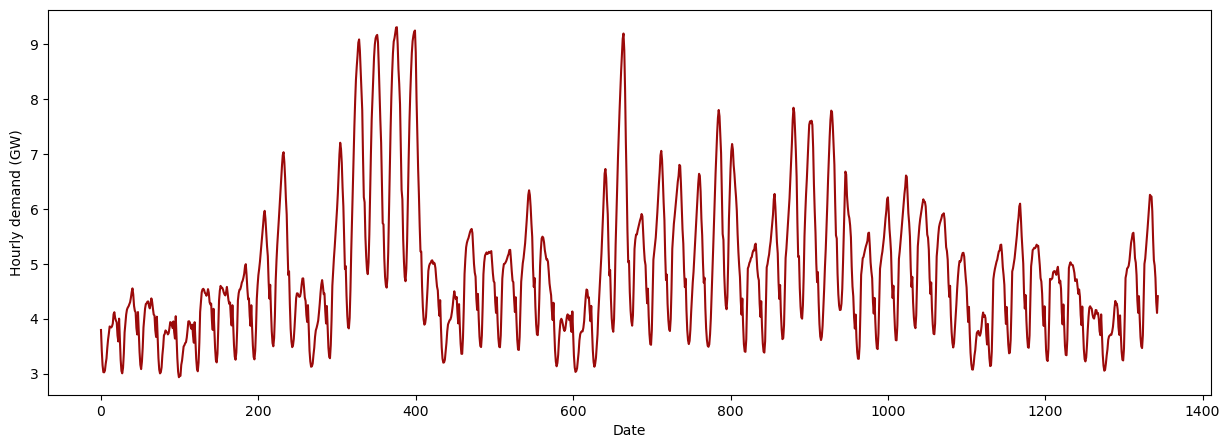

In [2]:
ts_problem = data.TimeSeriesProblem()
ts_problem.visualize_data();